In [ ]:
#For Connecting Colab to g drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
#import gensim.models.keyedvectors as word2vec #need to use due to depreceated model
from nltk.tokenize import RegexpTokenizer
%tensorflow_version 1.x 
import re
from keras.models import Sequential
from keras.layers.embeddings import Embedding
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.layers import LSTM, Dense, Dropout

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve,  roc_auc_score, classification_report


TensorFlow 1.x selected.


Using TensorFlow backend.


In [ ]:
tweetsData = pd.read_csv('/content/drive/My Drive/Twitter Sentiment/training.1600000.processed.noemoticon.csv', encoding='latin-1') #skiping these two rows as they have some bad data
print(tweetsData.shape)
tweetsData.head(n=10)

(1599999, 6)


,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew
5,0,1467811592,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,mybirch,Need a hug
6,0,1467811594,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,coZZ,@LOLTrish hey long time no see! Yes.. Rains a...
7,0,1467811795,Mon Apr 06 22:20:05 PDT 2009,NO_QUERY,2Hood4Hollywood,@Tatiana_K nope they didn't have it
8,0,1467812025,Mon Apr 06 22:20:09 PDT 2009,NO_QUERY,mimismo,@twittera que me muera ?
9,0,1467812416,Mon Apr 06 22:20:16 PDT 2009,NO_QUERY,erinx3leannexo,spring break in plain city... it's snowing


In [ ]:
DATASET_COLUMNS = ["Sentiment", "ids", "date", "flag", "user", "SentimentText"]
tweetsData.columns = DATASET_COLUMNS
tweetsData.head(n=10)

,Sentiment,ids,date,flag,user,SentimentText
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew
5,0,1467811592,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,mybirch,Need a hug
6,0,1467811594,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,coZZ,@LOLTrish hey long time no see! Yes.. Rains a...
7,0,1467811795,Mon Apr 06 22:20:05 PDT 2009,NO_QUERY,2Hood4Hollywood,@Tatiana_K nope they didn't have it
8,0,1467812025,Mon Apr 06 22:20:09 PDT 2009,NO_QUERY,mimismo,@twittera que me muera ?
9,0,1467812416,Mon Apr 06 22:20:16 PDT 2009,NO_QUERY,erinx3leannexo,spring break in plain city... it's snowing


In [ ]:
tweetsData.drop(['ids','date','flag','user'],axis = 1 ,inplace = True)
tweetsData.head(n=10)

,Sentiment,SentimentText
0,0,is upset that he can't update his Facebook by ...
1,0,@Kenichan I dived many times for the ball. Man...
2,0,my whole body feels itchy and like its on fire
3,0,"@nationwideclass no, it's not behaving at all...."
4,0,@Kwesidei not the whole crew
5,0,Need a hug
6,0,@LOLTrish hey long time no see! Yes.. Rains a...
7,0,@Tatiana_K nope they didn't have it
8,0,@twittera que me muera ?
9,0,spring break in plain city... it's snowing


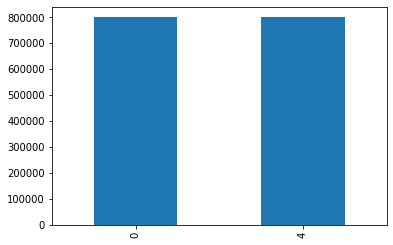

In [ ]:
#Data Exploration
tweetsData['Sentiment'].value_counts().sort_index().plot.bar()

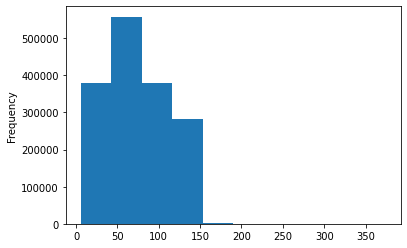

In [ ]:
tweetsData['SentimentText'].str.len().plot.hist()

In [ ]:
positif_data = tweetsData[tweetsData.Sentiment==4].iloc[:15000,:]
print(positif_data.shape)
negative_data = tweetsData[tweetsData.Sentiment==0].iloc[:15000,:]
print(negative_data.shape)

(15000, 2)
(15000, 2)


In [ ]:
tweetsData = pd.concat([positif_data,negative_data],axis = 0)
print(tweetsData.shape)
tweetsData.head(n=10)

(30000, 2)


,Sentiment,SentimentText
799999,4,I LOVE @Health4UandPets u guys r the best!!
800000,4,im meeting up with one of my besties tonight! ...
800001,4,"@DaRealSunisaKim Thanks for the Twitter add, S..."
800002,4,Being sick can be really cheap when it hurts t...
800003,4,@LovesBrooklyn2 he has that effect on everyone
800004,4,@ProductOfFear You can tell him that I just bu...
800005,4,@r_keith_hill Thans for your response. Ihad al...
800006,4,"@KeepinUpWKris I am so jealous, hope you had a..."
800007,4,"@tommcfly ah, congrats mr fletcher for finally..."
800008,4,@e4VoIP I RESPONDED Stupid cat is helping me ...


In [ ]:
#Data Cleaning
#Removing Twitter Handles (@user)
tweetsData['Clean_TweetText'] = tweetsData['SentimentText'].str.replace("@", "") 
tweetsData.head(n=10)

,Sentiment,SentimentText,Clean_TweetText
799999,4,I LOVE @Health4UandPets u guys r the best!!,I LOVE Health4UandPets u guys r the best!!
800000,4,im meeting up with one of my besties tonight! ...,im meeting up with one of my besties tonight! ...
800001,4,"@DaRealSunisaKim Thanks for the Twitter add, S...","DaRealSunisaKim Thanks for the Twitter add, Su..."
800002,4,Being sick can be really cheap when it hurts t...,Being sick can be really cheap when it hurts t...
800003,4,@LovesBrooklyn2 he has that effect on everyone,LovesBrooklyn2 he has that effect on everyone
800004,4,@ProductOfFear You can tell him that I just bu...,ProductOfFear You can tell him that I just bur...
800005,4,@r_keith_hill Thans for your response. Ihad al...,r_keith_hill Thans for your response. Ihad alr...
800006,4,"@KeepinUpWKris I am so jealous, hope you had a...","KeepinUpWKris I am so jealous, hope you had a ..."
800007,4,"@tommcfly ah, congrats mr fletcher for finally...","tommcfly ah, congrats mr fletcher for finally ..."
800008,4,@e4VoIP I RESPONDED Stupid cat is helping me ...,e4VoIP I RESPONDED Stupid cat is helping me t...


In [ ]:
#Removing links
tweetsData['Clean_TweetText'] = tweetsData['Clean_TweetText'].str.replace(r"http\S+", "") 
tweetsData.head(n=10)

,Sentiment,SentimentText,Clean_TweetText
799999,4,I LOVE @Health4UandPets u guys r the best!!,I LOVE Health4UandPets u guys r the best!!
800000,4,im meeting up with one of my besties tonight! ...,im meeting up with one of my besties tonight! ...
800001,4,"@DaRealSunisaKim Thanks for the Twitter add, S...","DaRealSunisaKim Thanks for the Twitter add, Su..."
800002,4,Being sick can be really cheap when it hurts t...,Being sick can be really cheap when it hurts t...
800003,4,@LovesBrooklyn2 he has that effect on everyone,LovesBrooklyn2 he has that effect on everyone
800004,4,@ProductOfFear You can tell him that I just bu...,ProductOfFear You can tell him that I just bur...
800005,4,@r_keith_hill Thans for your response. Ihad al...,r_keith_hill Thans for your response. Ihad alr...
800006,4,"@KeepinUpWKris I am so jealous, hope you had a...","KeepinUpWKris I am so jealous, hope you had a ..."
800007,4,"@tommcfly ah, congrats mr fletcher for finally...","tommcfly ah, congrats mr fletcher for finally ..."
800008,4,@e4VoIP I RESPONDED Stupid cat is helping me ...,e4VoIP I RESPONDED Stupid cat is helping me t...


In [ ]:
#Removing Punctuations, Numbers, and Special Characters
tweetsData['Clean_TweetText'] = tweetsData['Clean_TweetText'].str.replace("[^a-zA-Z]", " ") 
tweetsData.head(n=10)

,Sentiment,SentimentText,Clean_TweetText
799999,4,I LOVE @Health4UandPets u guys r the best!!,I LOVE Health UandPets u guys r the best
800000,4,im meeting up with one of my besties tonight! ...,im meeting up with one of my besties tonight ...
800001,4,"@DaRealSunisaKim Thanks for the Twitter add, S...",DaRealSunisaKim Thanks for the Twitter add Su...
800002,4,Being sick can be really cheap when it hurts t...,Being sick can be really cheap when it hurts t...
800003,4,@LovesBrooklyn2 he has that effect on everyone,LovesBrooklyn he has that effect on everyone
800004,4,@ProductOfFear You can tell him that I just bu...,ProductOfFear You can tell him that I just bur...
800005,4,@r_keith_hill Thans for your response. Ihad al...,r keith hill Thans for your response Ihad alr...
800006,4,"@KeepinUpWKris I am so jealous, hope you had a...",KeepinUpWKris I am so jealous hope you had a ...
800007,4,"@tommcfly ah, congrats mr fletcher for finally...",tommcfly ah congrats mr fletcher for finally ...
800008,4,@e4VoIP I RESPONDED Stupid cat is helping me ...,e VoIP I RESPONDED Stupid cat is helping me t...


In [ ]:
#Transforming text to lowercase
tweetsData['Clean_TweetText'].apply(lambda x: x.lower()) 
tweetsData['Clean_TweetText'] = tweetsData['Clean_TweetText'].apply(lambda x: re.sub('[^a-zA-z0-9\s]', '', x))
tweetsData.head(n=10)

,Sentiment,SentimentText,Clean_TweetText
799999,4,I LOVE @Health4UandPets u guys r the best!!,I LOVE Health UandPets u guys r the best
800000,4,im meeting up with one of my besties tonight! ...,im meeting up with one of my besties tonight ...
800001,4,"@DaRealSunisaKim Thanks for the Twitter add, S...",DaRealSunisaKim Thanks for the Twitter add Su...
800002,4,Being sick can be really cheap when it hurts t...,Being sick can be really cheap when it hurts t...
800003,4,@LovesBrooklyn2 he has that effect on everyone,LovesBrooklyn he has that effect on everyone
800004,4,@ProductOfFear You can tell him that I just bu...,ProductOfFear You can tell him that I just bur...
800005,4,@r_keith_hill Thans for your response. Ihad al...,r keith hill Thans for your response Ihad alr...
800006,4,"@KeepinUpWKris I am so jealous, hope you had a...",KeepinUpWKris I am so jealous hope you had a ...
800007,4,"@tommcfly ah, congrats mr fletcher for finally...",tommcfly ah congrats mr fletcher for finally ...
800008,4,@e4VoIP I RESPONDED Stupid cat is helping me ...,e VoIP I RESPONDED Stupid cat is helping me t...


In [ ]:
#Remove stop words
import nltk
nltk.download('stopwords')
stopwords=nltk.corpus.stopwords.words('english')
def remove_stopwords(text):
    clean_text=' '.join([word for word in text.split() if word not in stopwords])
    return clean_text
tweetsData['Clean_TweetText'] = tweetsData['Clean_TweetText'].apply(lambda text : remove_stopwords(text.lower()))
tweetsData.head(n=10)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,Sentiment,SentimentText,Clean_TweetText
799999,4,I LOVE @Health4UandPets u guys r the best!!,love health uandpets u guys r best
800000,4,im meeting up with one of my besties tonight! ...,im meeting one besties tonight cant wait girl ...
800001,4,"@DaRealSunisaKim Thanks for the Twitter add, S...",darealsunisakim thanks twitter add sunisa got ...
800002,4,Being sick can be really cheap when it hurts t...,sick really cheap hurts much eat real food plu...
800003,4,@LovesBrooklyn2 he has that effect on everyone,lovesbrooklyn effect everyone
800004,4,@ProductOfFear You can tell him that I just bu...,productoffear tell burst laughing really loud ...
800005,4,@r_keith_hill Thans for your response. Ihad al...,r keith hill thans response ihad already find ...
800006,4,"@KeepinUpWKris I am so jealous, hope you had a...",keepinupwkris jealous hope great time vegas li...
800007,4,"@tommcfly ah, congrats mr fletcher for finally...",tommcfly ah congrats mr fletcher finally joini...
800008,4,@e4VoIP I RESPONDED Stupid cat is helping me ...,e voip responded stupid cat helping type forgi...


In [ ]:
#Text Tokenization and Normalization
tweetsData['Clean_TweetText'] = tweetsData['Clean_TweetText'].apply(lambda x: x.split())
tweetsData.head(n=10)

,Sentiment,SentimentText,Clean_TweetText
799999,4,I LOVE @Health4UandPets u guys r the best!!,"[love, health, uandpets, u, guys, r, best]"
800000,4,im meeting up with one of my besties tonight! ...,"[im, meeting, one, besties, tonight, cant, wai..."
800001,4,"@DaRealSunisaKim Thanks for the Twitter add, S...","[darealsunisakim, thanks, twitter, add, sunisa..."
800002,4,Being sick can be really cheap when it hurts t...,"[sick, really, cheap, hurts, much, eat, real, ..."
800003,4,@LovesBrooklyn2 he has that effect on everyone,"[lovesbrooklyn, effect, everyone]"
800004,4,@ProductOfFear You can tell him that I just bu...,"[productoffear, tell, burst, laughing, really,..."
800005,4,@r_keith_hill Thans for your response. Ihad al...,"[r, keith, hill, thans, response, ihad, alread..."
800006,4,"@KeepinUpWKris I am so jealous, hope you had a...","[keepinupwkris, jealous, hope, great, time, ve..."
800007,4,"@tommcfly ah, congrats mr fletcher for finally...","[tommcfly, ah, congrats, mr, fletcher, finally..."
800008,4,@e4VoIP I RESPONDED Stupid cat is helping me ...,"[e, voip, responded, stupid, cat, helping, typ..."


In [ ]:
from nltk.stem.porter import * 
stemmer = PorterStemmer() 
tweetsData['Clean_TweetText'] = tweetsData['Clean_TweetText'].apply(lambda x: [stemmer.stem(i) for i in x])
tweetsData.head(n=10)

,Sentiment,SentimentText,Clean_TweetText
799999,4,I LOVE @Health4UandPets u guys r the best!!,"[love, health, uandpet, u, guy, r, best]"
800000,4,im meeting up with one of my besties tonight! ...,"[im, meet, one, besti, tonight, cant, wait, gi..."
800001,4,"@DaRealSunisaKim Thanks for the Twitter add, S...","[darealsunisakim, thank, twitter, add, sunisa,..."
800002,4,Being sick can be really cheap when it hurts t...,"[sick, realli, cheap, hurt, much, eat, real, f..."
800003,4,@LovesBrooklyn2 he has that effect on everyone,"[lovesbrooklyn, effect, everyon]"
800004,4,@ProductOfFear You can tell him that I just bu...,"[productoffear, tell, burst, laugh, realli, lo..."
800005,4,@r_keith_hill Thans for your response. Ihad al...,"[r, keith, hill, than, respons, ihad, alreadi,..."
800006,4,"@KeepinUpWKris I am so jealous, hope you had a...","[keepinupwkri, jealou, hope, great, time, vega..."
800007,4,"@tommcfly ah, congrats mr fletcher for finally...","[tommcfli, ah, congrat, mr, fletcher, final, j..."
800008,4,@e4VoIP I RESPONDED Stupid cat is helping me ...,"[e, voip, respond, stupid, cat, help, type, fo..."


In [ ]:
#Stitching the tokens back together
tweetsData['Clean_TweetText'] = tweetsData['Clean_TweetText'].apply(lambda x: ' '.join([w for w in x]))
tweetsData.head(n=10)

,Sentiment,SentimentText,Clean_TweetText
799999,4,I LOVE @Health4UandPets u guys r the best!!,love health uandpet u guy r best
800000,4,im meeting up with one of my besties tonight! ...,im meet one besti tonight cant wait girl talk
800001,4,"@DaRealSunisaKim Thanks for the Twitter add, S...",darealsunisakim thank twitter add sunisa got m...
800002,4,Being sick can be really cheap when it hurts t...,sick realli cheap hurt much eat real food plu ...
800003,4,@LovesBrooklyn2 he has that effect on everyone,lovesbrooklyn effect everyon
800004,4,@ProductOfFear You can tell him that I just bu...,productoffear tell burst laugh realli loud tha...
800005,4,@r_keith_hill Thans for your response. Ihad al...,r keith hill than respons ihad alreadi find an...
800006,4,"@KeepinUpWKris I am so jealous, hope you had a...",keepinupwkri jealou hope great time vega like ...
800007,4,"@tommcfly ah, congrats mr fletcher for finally...",tommcfli ah congrat mr fletcher final join twi...
800008,4,@e4VoIP I RESPONDED Stupid cat is helping me ...,e voip respond stupid cat help type forgiv error


In [ ]:
#Removing small words
tweetsData['Clean_TweetText'] = tweetsData['Clean_TweetText'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
tweetsData.head(n=10)

,Sentiment,SentimentText,Clean_TweetText
799999,4,I LOVE @Health4UandPets u guys r the best!!,love health uandpet best
800000,4,im meeting up with one of my besties tonight! ...,meet besti tonight cant wait girl talk
800001,4,"@DaRealSunisaKim Thanks for the Twitter add, S...",darealsunisakim thank twitter sunisa meet show...
800002,4,Being sick can be really cheap when it hurts t...,sick realli cheap hurt much real food friend m...
800003,4,@LovesBrooklyn2 he has that effect on everyone,lovesbrooklyn effect everyon
800004,4,@ProductOfFear You can tell him that I just bu...,productoffear tell burst laugh realli loud tha...
800005,4,@r_keith_hill Thans for your response. Ihad al...,keith hill than respons ihad alreadi find answer
800006,4,"@KeepinUpWKris I am so jealous, hope you had a...",keepinupwkri jealou hope great time vega like ...
800007,4,"@tommcfly ah, congrats mr fletcher for finally...",tommcfli congrat fletcher final join twitter
800008,4,@e4VoIP I RESPONDED Stupid cat is helping me ...,voip respond stupid help type forgiv error


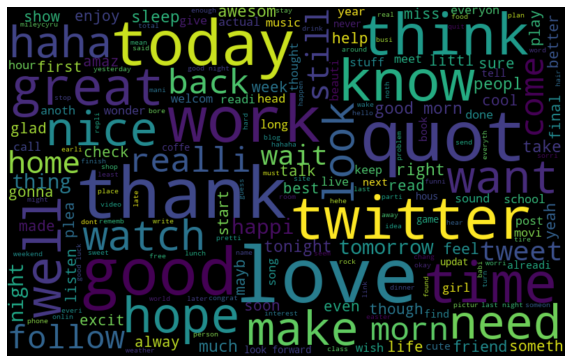

In [ ]:
positive_words =' '.join([text for text in tweetsData['Clean_TweetText'][tweetsData['Sentiment'] == 4]]) 
from wordcloud import WordCloud 
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(positive_words)

plt.figure(figsize=(10, 7)) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis('off') 
plt.show()

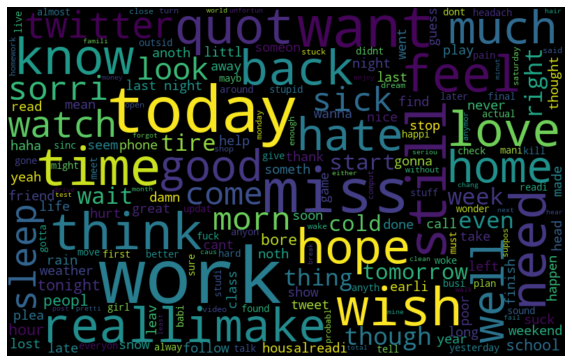

In [ ]:
negative_words =' '.join([text for text in tweetsData['Clean_TweetText'][tweetsData['Sentiment'] == 0]]) 
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(negative_words)

plt.figure(figsize=(10, 7)) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis('off') 
plt.show()

In [ ]:
tokenizer = Tokenizer(num_words=10000, split=" ")
tokenizer.fit_on_texts(tweetsData['Clean_TweetText'].values)

X = tokenizer.texts_to_sequences(tweetsData['Clean_TweetText'].values)
X = pad_sequences(X) # padding our text vector so they all have the same length
X[:5]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    6, 1122,   81],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,  120, 1310,   46,   74,   33,   96,   87],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    8,   14,  120,   60,  792, 1706],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,   56,   19,
        1380,  122,   28,  236,  214,   45,   23,  709],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0, 1210,   67]], dtype=int32)

In [ ]:
#Creating model
model = Sequential()
model.add(Embedding(10000, 256, input_length=X.shape[1]))
model.add(Dropout(0.3))
model.add(LSTM(256, return_sequences=True, dropout=0.3, recurrent_dropout=0.2))
model.add(LSTM(256, dropout=0.3, recurrent_dropout=0.2))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 19, 256)           1280000   
_________________________________________________________________
dropout_1 (Dropout)          (None, 19, 256)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 19, 256)           525312    
_________________________________________________________________
lstm_2 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 514       
Total params: 2,331,138
Trainable params: 2,331,138
Non-trainable params: 0
_________________________________________________________________


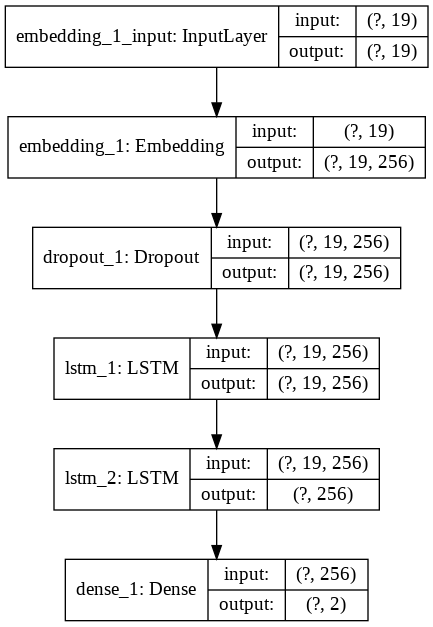

In [ ]:
#Visualize the Model
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
y = pd.get_dummies(tweetsData['Sentiment']).values
[print(tweetsData['Sentiment'][i], y[i]) for i in range(0,5)]

0 [0 1]
0 [0 1]
0 [0 1]
0 [0 1]
0 [0 1]


[None, None, None, None, None]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

#Training our model


In [ ]:

model.fit(X_train, y_train, epochs=8, batch_size=32, verbose=2)


Epoch 1/8
 - 93s - loss: 0.5848 - accuracy: 0.6811
Epoch 2/8
 - 91s - loss: 0.5023 - accuracy: 0.7502
Epoch 3/8
 - 92s - loss: 0.4593 - accuracy: 0.7811
Epoch 4/8
 - 92s - loss: 0.4154 - accuracy: 0.8048
Epoch 5/8
 - 91s - loss: 0.3698 - accuracy: 0.8263
Epoch 6/8
 - 91s - loss: 0.3257 - accuracy: 0.8461
Epoch 7/8
 - 91s - loss: 0.2932 - accuracy: 0.8608
Epoch 8/8
 - 92s - loss: 0.2699 - accuracy: 0.8736


In [ ]:
#model.save('Sentiment_Analysis.h5')

In [ ]:
#Testing our model
score, acc = model.evaluate(X_test, y_test, verbose = 2, batch_size=32)
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5) 

In [ ]:
predictions = model.predict(X_test)

[print(tweetsData['Clean_TweetText'][i], predictions[i], y_test[i]) for i in range(0, 5)]

upset updat facebook text might result school today also blah [0.01014661 0.98985344] [0 1]
kenichan dive mani time ball manag save rest bound [0.32769814 0.6723018 ] [0 1]
whole bodi feel itchi like fire [0.7343994  0.26560065] [0 1]
nationwideclass behav [0.00466597 0.9953341 ] [1 0]
kwesidei whole crew [0.74757713 0.25242287] [0 1]


[None, None, None, None, None]

In [ ]:
pos_count, neg_count = 0, 0
real_pos,  real_neg = 0, 0
for i, prediction in enumerate(predictions):
    if np.argmax(prediction)==1:
        pos_count += 1
    else:
        neg_count += 1
    
    if np.argmax(y_test[i])==1:
        real_pos += 1
    else:
        real_neg +=1

print('Positive predictions:', pos_count)
print('Negative predictions:', neg_count)
print('Real positive:', real_pos)
print('Real negative:', real_neg)

Positive predictions: 3008
Negative predictions: 2992
Real positive: 2987
Real negative: 3013


In [ ]:
#F1 Score, Recall and Precision
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))

              precision    recall  f1-score   support

    Negative       0.69      0.69      0.69      3013
    Positive       0.69      0.69      0.69      2987

   micro avg       0.69      0.69      0.69      6000
   macro avg       0.69      0.69      0.69      6000
weighted avg       0.69      0.69      0.69      6000
 samples avg       0.69      0.69      0.69      6000



In [ ]:
!pip install -q cross_validation

In [ ]:
from sklearn.model_selection import KFold 
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

def classify(X_train, X_test, ngram=(1, 1)):
    # F1 scores for each fold
    scores = []

    # Provides train/test indices to split data in train, validation sets.
    k_fold = KFold(n_splits= len(X_train))

    # Used to convert a collection of text docuements to a matrix of token counts => Bag of words
    count_vectorizer = CountVectorizer(ngram_range=ngram)

    # Confusion matrix with TP/FP/TN/FN
    confusion = np.array([[0, 0], [0, 0]])

    for training_indices, validation_indices in k_fold:
        training_features = count_vectorizer.fit_transform(X_train.iloc[training_indices]['Clean_TweetText'].values)
        training_labels = X_train.iloc[training_indices]['Sentiment'].values

        validation_features = count_vectorizer.transform(X_train.iloc[validation_indices]['Clean_TweetText'].values)
        validation_labels = X_train.iloc[validation_indices]['Sentiment'].values

        classifier = MultinomialNB()
        classifier.fit(training_features, training_labels)
        validation_predictions = classifier.predict(validation_features)

        confusion += confusion_matrix(validation_labels, validation_predictions)
        score = f1_score(validation_labels, validation_predictions)
        scores.append(score)
    
    return (sum(scores) / len(scores)), confusion

score, confusion = classify(X_train, X_test)

print('Total tweets classified: ' + str(len(X_train)))
print('Score: ' +  str(sum(scores) / len(scores)))
print('Confusion matrix:')
print(confusion)


In [ ]:
#import logging
#logging.basicConfig(format='%(asctime)s : %(levelname) s : %(message)s', level=logging.INFO)

#Set random seed
#np.random.seed(24)

In [ ]:
labels = ['Positive', 'Negative']
def plot_confusion_matrix(cm, labels, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
print 'Confusion matrix without normalization'
plt.figure()
plot_confusion_matrix(confusion, labels)

In [ ]:
confusion_normalized = confusion.astype(float) / confusion.sum(axis=1)[:, np.newaxis]
print 'Confusion matrix normalized'
plt.figure()
plot_confusion_matrix(confusion_normalized, labels, title='Confusion matrix normalized')

In [ ]:
#Other accuracy metrices
y_pred1 = (y_pred > 0.5)
#confusion metrix
cm = confusion_matrix(y_test, y_pred1)
print(cm)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))
print(accuracy_score(y_test, predictions))

In [ ]:
model.save('sentiment_analysis.h5')

In [ ]:
#Testing our model
#analyze the results
score, acc = model.evaluate(X_test, Y_test, verbose = 2, batch_size=batch_size)
y_pred = model.predict(X_test)

#ROC AUC curve
rocAuc = roc_auc_score(Y_test, y_pred)

falsePositiveRate, truePositiveRate, _ = roc_curve(Y_test, y_pred)

plt.figure()

plt.plot(falsePositiveRate, truePositiveRate, color='green',
         lw=3, label='ROC curve (area = %0.2f)' % rocAuc)
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic of Sentiiment Analysis Model')
plt.legend(loc="lower right")
plt.show()


#Other accuracy metrices
y_pred = (y_pred > 0.5)

#confusion metrix
cm = confusion_matrix(Y_test, y_pred)
print(cm)

#F1 Score, Recall and Precision
print(classification_report(Y_test, y_pred, target_names=['Positive', 'Negative']))


#from keras.models import load_model
#
#load_model('sentiment_analysis_twitter_cnn_lstm.h5')


predictions = model.predict(X_test)

[print(data['text'][i], predictions[i], y_test[i]) for i in range(0, 5)]

In [ ]:

pos_count, neu_count, neg_count = 0, 0, 0
real_pos, real_neu, real_neg = 0, 0, 0
for i, prediction in enumerate(predictions):
    if np.argmax(prediction)==2:
        pos_count += 1
    elif np.argmax(prediction)==1:
        neu_count += 1
    else:
        neg_count += 1
    
    if np.argmax(y_test[i])==2:
        real_pos += 1
    elif np.argmax(y_test[i])==1:    
        real_neu += 1
    else:
        real_neg +=1

print('Positive predictions:', pos_count)
print('Neutral predictions:', neu_count)
print('Negative predictions:', neg_count)
print('Real positive:', real_pos)
print('Real neutral:', real_neu)
print('Real negative:', real_neg)

In [ ]:
#Dividing the dataset into features and lables
tweets = tweetsData['SentimentText']
labels = tweetsData['Sentiment']

In [ ]:
#check the distribution of lebels
labels_count = labels.value_counts()
labels_count.plot(kind="bar")
print(labels.value_counts())

In [ ]:
#Lower and split the dialog
#and use regular expression to keep only letters we will use nltk Regular expression package
tkr = RegexpTokenizer('[a-zA-Z@]+')

tweets_split = []

for i, line in enumerate(tweets):
    #print(line)
    tweet = str(line).lower().split()
    tweet = tkr.tokenize(str(tweet))
    tweets_split.append(tweet)

print(tweets_split[1])

In [ ]:
!pip install wget
!wget -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

from gensim import models
w2vModel = models.KeyedVectors.load_word2vec_format('https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz', binary=True, limit=36397) #limit=50000,611889

#Convert words to integers
tokenizer = Tokenizer()
tokenizer.fit_on_texts(tweets_split)
X = tokenizer.texts_to_sequences(tweets_split)

#length of tweet to consider
maxlentweet = 30
#add padding
X = pad_sequences(X, maxlen=maxlentweet)
print(X.shape)
#../GoogleNews-vectors-negative300.bin

In [ ]:
#create a embedding layer using Google pre triained word2vec (50000 words)
word_index = tokenizer.word_index
embedding_layer = Embedding(input_dim=w2vModel.syn0.shape[0], output_dim=w2vModel.syn0.shape[1], weights=[w2vModel.syn0], 
                            input_length=X.shape[1])
#len(word_index) + 1
#w2vModel.syn0.shape[0]

In [ ]:
#create model combining LSTM with 1D Convonutional layer and MaxPool layer
lstm_out = 150

model = Sequential()
model.add(embedding_layer)
model.add(Conv1D(filters=64, kernel_size=5, activation='relu', padding='causal')) #64,5
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.7))
model.add(LSTM(units=lstm_out))
model.add(Dropout(0.7))
model.add(Dense(1, activation='sigmoid'))#, kernel_regularizer=regularizers.l2(0.01), activity_regularizer=regularizers.l1(0.01)))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())


In [ ]:
#split dataset
X_train, X_test, Y_train, Y_test = train_test_split(X, labels, test_size= 0.1, random_state = 24)
X_train= X_train.reshape(-1, 1)
Y_train= Y_train.reshape(-1, 1)
X_test = X_test.reshape(-1, 1)
#fit model
batch_size = 32
model.fit(X_train , Y_train, epochs=1, verbose=1, batch_size=64)

